In [1]:
from itertools import product

import numpy as np
import pandas as pd
from functions import *


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [15]:
from itertools import product
from sys import argv

import numpy as np
import pandas as pd
from functions import *
from statsmodels.nonparametric.kernel_regression import KernelReg


# heteroscedastic = [False]
# p must be p>4
p = [10]
n = [2000]
#treatment_to_noise_ratio = np.logspace(start=0.0, stop=1.25, num=50) # from 0.25 to 20
#treatment_to_noise_ratio = np.linspace(start=1.0, stop = 8.00, num=50)
 # 2.5 - 7.5
    
treatment_to_noise_ratio = [1,2,3,4,15.0]

# (n, p, X_dist, X_correlation, eps_dist, error_type, functional_form, non_zero_beta_count, uniform_upper, standardized_X, method, sim_id)

n_sims = 3


main_effect_cases = ["const", "linear","non-linear"]
#main_effect_cases = ["non-linear"]

treatment_cases = ["binary","gaussian"]

methods = {
    "quantreg_forest": quantreg_forest,
    #"pred_band_mean_based_new": pred_band_mean_based_new,
    #"pred_band_weighted_mean_based": pred_band_weighted_mean_based,
    #"pred_band_quantile_based_rf": pred_band_quantile_based_rf,
    #"pred_band_cdf_based": pred_band_cdf_based,
}


methods_keys = list(methods.keys())

simulation_ids = np.arange(n_sims)

index = product(n, p, treatment_to_noise_ratio, main_effect_cases, methods_keys, treatment_cases, simulation_ids)

index = pd.MultiIndex.from_tuples(
    index,
    names=(
        "n",
        "p",
        "treatment_to_noise_ratio",
        "main_effect_case",
        "conformal_method",
        "treatment_case",
        "simulation_id",
    ),
)

df = pd.DataFrame(
    columns=[
        "mean_interval_length_qf",
        "mean_coverage_qf",
        "mean_oracle_length",
        "share_signif_oracles_given_ite_nonzero",
        "share_signif_intervals_given_ite_nonzero"  
    ],
    index=index,
)


In [20]:
df.head(15)

mean_interval_length_qf  \
n    p  treatment_to_noise_ratio main_effect_case conformal_method treatment_case simulation_id                           
2000 10 1.0                      const            quantreg_forest  binary         0                            6.764362   
                                                                                  1                            6.873536   
                                                                                  2                            6.583224   
                                                                   gaussian       0                            7.493105   
                                                                                  1                            7.217203   
                                                                                  2                            7.297959   
                                 linear           quantreg_forest  binary         0                           12.809313   
                                                                                  1                           12.558475   
                                                                                  2                           12.734607   
                                                                   gaussian       0                           13.496401   
                                                                                  1                           13.261215   
                                                                                  2                           13.897051   
                                 non-linear       quantreg_forest  binary         0                           13.655668   
                                                                                  1                           12.859917   
                                                                                  2                           13.143584   

                                                                                                mean_coverage_qf  \
n    p  treatment_to_noise_ratio main_effect_case conformal_method treatment_case simulation_id                    
2000 10 1.0                      const            quantreg_forest  binary         0                       0.9775   
                                                                                  1                        0.981   
                                                                                  2                        0.983   
                                                                   gaussian       0                       0.9885   
                                                                                  1                       0.9805   
                                                                                  2                       0.9865   
                                 linear           quantreg_forest  binary         0                       0.9995   
                                                                                  1                          1.0   
                                                                                  2                          1.0   
                                                                   gaussian       0                          1.0   
                                                                                  1                          1.0   
                                                                                  2                          1.0   
                                 non-linear       quantreg_forest  binary         0                       0.9985   
                                                                                  1                       0.9985   
                                                                                  2                        0.999   

                               

In [17]:
for index in df.index:
    print(str(index))
    pred_samples = 2000
    total_sample = index[0] + pred_samples
    
    # generate train and test sample:
    ite, mu_1, mu_0, eps_1, eps_0, y_obs, X, W = dgp_ate_zero(n = index[0],
                                                             p = index[1], 
                                                             effect_size = index[2],
                                                             main_effect_case= index[3],
                                                             treatment_case = index[5])
   
    # split the generated data into respective categories, one split for each counterfactual:
    
    # Y(1) | W = 1:
    #X_train_1, y_train_1 = X[W==1], y_obs[W==1]
    
    # Y(0) | W = 0:
    #X_train_0, y_train_0 = X[W==0], y_obs[W==0]
    
    # draw new samples for later prediction:
    ite_pred, mu_1_pred, mu_0_pred, eps_1_pred, eps_0_pred, y_obs_pred, X_pred, W_pred = dgp_ate_zero(n = pred_samples,
                                                                     p = index[1], 
                                                                     effect_size = index[2],
                                                                     main_effect_case= index[3],
                                                                     treatment_case = index[5])

    
    res_y_1 = quantreg_forest(X_train=X[W==1], y_train=y_obs[W==1], X_test=X_pred, lower=0.05, upper=0.95, nodesize=10)
    res_y_0 = quantreg_forest(X_train=X[W==0], y_train=y_obs[W==0], X_test=X_pred, lower=0.05, upper=0.95, nodesize=10)
    
    
    lower = res_y_1[:, 0] - res_y_0[:, 1] 
    upper = res_y_1[:, 1] - res_y_0[:, 0] 
    
    ite_bands = np.stack((lower.flatten(), upper.flatten()), axis=1)
                                                                                                         
    length_bands = ite_bands[:, 1] - ite_bands[:, 0]
    mean_interval_length = np.mean(length_bands)

    in_the_range = np.sum(
        (ite_pred.flatten() >= ite_bands[:, 0]) & (ite_pred.flatten() <= ite_bands[:, 1])
    )
    mean_coverage = in_the_range / len(ite_pred)
    
    # get oracle intervals for the ite's:
    oracle_ints = np.stack(get_oracle_intervals(*calc_normal_params(mu_1= mu_1_pred, mu_0= mu_0_pred, X =X_pred, heteroscedastic=False)), axis=0)
    length_oracle_ints = oracle_ints[:, 1] - oracle_ints[:, 0]
    mean_oracle_length = np.mean(length_oracle_ints)
    
    assert oracle_ints.shape[0] == ite_bands.shape[0]
    assert oracle_ints.shape[1] == ite_bands.shape[1]
    
    
    df.at[index, "mean_interval_length_qf"] = mean_interval_length
    df.at[index, "mean_coverage_qf"] = mean_coverage
    df.at[index, "mean_oracle_length"] = mean_oracle_length
    
    #df.at[index, "share_intervals_signif_if_oracle_signif"] = share_signif_fun(oracle_ints, ite_bands)                                                       
    df.at[index, "share_signif_oracles_given_ite_nonzero"] = share_signif_oracles(oracle_intervals=oracle_ints, ite_vals=ite_pred)                                                                                              
    df.at[index, "share_signif_intervals_given_ite_nonzero"] = share_signif_intervals_given_ite_not_zero(ite_pred_intervals=ite_bands, ite_vals=ite_pred)
                                                                                                         


(2000, 10, 1.0, 'const', 'quantreg_forest', 'binary', 0)
(2000, 10, 1.0, 'const', 'quantreg_forest', 'binary', 1)
(2000, 10, 1.0, 'const', 'quantreg_forest', 'binary', 2)
(2000, 10, 1.0, 'const', 'quantreg_forest', 'gaussian', 0)
(2000, 10, 1.0, 'const', 'quantreg_forest', 'gaussian', 1)
(2000, 10, 1.0, 'const', 'quantreg_forest', 'gaussian', 2)
(2000, 10, 1.0, 'linear', 'quantreg_forest', 'binary', 0)
(2000, 10, 1.0, 'linear', 'quantreg_forest', 'binary', 1)
(2000, 10, 1.0, 'linear', 'quantreg_forest', 'binary', 2)
(2000, 10, 1.0, 'linear', 'quantreg_forest', 'gaussian', 0)
(2000, 10, 1.0, 'linear', 'quantreg_forest', 'gaussian', 1)
(2000, 10, 1.0, 'linear', 'quantreg_forest', 'gaussian', 2)
(2000, 10, 1.0, 'non-linear', 'quantreg_forest', 'binary', 0)
(2000, 10, 1.0, 'non-linear', 'quantreg_forest', 'binary', 1)
(2000, 10, 1.0, 'non-linear', 'quantreg_forest', 'binary', 2)
(2000, 10, 1.0, 'non-linear', 'quantreg_forest', 'gaussian', 0)
(2000, 10, 1.0, 'non-linear', 'quantreg_forest',

In [5]:
# generate train and test sample:
ite, mu_1, mu_0, eps_1, eps_0, y_obs, X, W = dgp_ate_zero(n = 20000,
                                                            p = 10,
                                                             effect_size = 1.0,
                                                             main_effect_case= "linear",
                                                             treatment_case = "binary")

In [8]:
X_train_1, X_conf_1, y_train_1, y_conf_1 = train_test_split(
        X[W==1], y_obs[W==1], test_size=0.3, train_size=0.7)
    
# Y(0) | W = 0:
X_train_0, X_conf_0, y_train_0, y_conf_0 = train_test_split(
        X[W==0], y_obs[W==0], test_size=0.3, train_size=0.7)

In [6]:
ite_pred, mu_1_pred, mu_0_pred, eps_1_pred, eps_0_pred, y_obs_pred, X_pred, W_pred = dgp_ate_zero(n = 2000,
                                                                     p = 10, 
                                                                     effect_size = 1.0,
                                                                     main_effect_case= "linear",
                                                                     treatment_case = "binary")

In [7]:
res = quantreg_forest(X_train=X[W==1], y_train=y_obs[W==1], X_test=X_pred, lower=0.05, upper=0.95, nodesize=10)

In [13]:
X_train_1, y_train_1 = X[W==1], y_obs[W==1]

In [ ]:
RandomForestRegressor

In [27]:
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import check_X_y, check_array
from sklearn.utils.validation import check_is_fitted
import matplotlib.pyplot as plt
from sklearn.ensemble._gb import BaseGradientBoosting

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from copy import deepcopy

In [59]:
class SplitConformalRegressor(BaseEstimator, RegressorMixin):
    valid_methods_ = ["mean-based","weighted-mean-based","quantile-based","cdf-based"]
    
    def __init__(self, estimator = None, method= "mean-based", conf_size=0.5):
        if isinstance(estimator, RegressorMixin):
            self.estimator = estimator
        else:
            raise ValueError("Invalid estimator argument. Must be a regressor.")
            
        if method in SplitConformalRegressor.valid_methods_:
            self.method = method
        else:
            raise ValueError("Invalid method. Allowed values are 'mean-based','weighted-mean-based','quantile-based', and 'cdf-based'.")
            
        if (conf_size > 0.0) & (conf_size < 1.0):
            self.conf_size = conf_size
        else:
            raise ValueError("Invalid size for the conformalization size. Accepted values are between 0 and 1.")
            
            
    def _check_estimator(self, estimator = None):
        if estimator is None:
            return LinearRegression()
        
        if not hasattr(estimator, "fit") and not hasattr(estimator, "predict"):
            raise ValueError("Invalid estimator. Please provide a regressor with fit and predict methods.")
     
        return estimator
    
    def fit(self, X, y):
        """
        Fit estimator and compute residuals used for prediction intervals.
        Fit the base estimator under the ``single_estimator_`` attribute.
        Fit all cross-validated estimator clones
        and rearrange them into a list, the ``estimators_`` attribute.
        Out-of-fold residuals are stored under the ``residuals_`` attribute.

        """
        # checks
        estimator = self._check_estimator(self.estimator)
        X, y = check_X_y(X, y, force_all_finite=False, dtype=["float64", "int", "object"])
        
        # initialization
        self.estimators_ = []
        y_pred = np.empty_like(y, dtype=float)

        # training
        if self.method == "mean-based":
            self.mu_hat_ = estimator.fit(X, y)
            
        if self.method == "weighted-mean-based":
            self.mu_hat_ = estimator.fit(X, y)
            self.mu_hat_train_residuals_ = self.mu_hat_.predict(X)
            
            self.fitted_abs_res_ = np.abs(y.flatten() - self.mu_hat_train_residuals_.flatten())
            self.rho_hat_ = estimator.fit(X, self.fitted_abs_res_) 

        return self
    
    
    def predict_intervals(self, X_conf, y_conf, X_pred, alpha):
        X_conf, y_conf = check_X_y(X_conf, y_conf, force_all_finite=False, dtype=["float64", "int", "object"])
        X_pred = check_array(X_pred, force_all_finite=False, dtype=["float64", "object"])
        
        if self.method == "mean-based":
            check_is_fitted(self,["mu_hat_"])
            y_pred_hat = self.mu_hat_.predict(X_pred)
            y_conf_hat = self.mu_hat_.predict(X_conf)
            
            conf_scores = np.abs(y_conf - y_conf_hat)
            k = (1 - alpha) * (1.0 / len(y_conf) + 1)
            d = np.quantile(conf_scores, k)

            pred_band_upper = y_pred_hat + d
            pred_band_lower = y_pred_hat - d

            res = np.stack((pred_band_lower.flatten(), pred_band_upper.flatten()), axis=1)
            return res, y_pred_hat
        
        if self.method == "weighted-mean-based":
            check_is_fitted(self,["mu_hat_","mu_hat_train_residuals_","fitted_abs_res_","rho_hat_"])
            
            y_pred_hat = self.mu_hat_.predict(X_pred)
            y_conf_hat = self.mu_hat_.predict(X_conf)
            
            y_pred_mad_hat = self.rho_hat_.predict(X_pred)
            y_conf_mad_hat = self.rho_hat_.predict(X_conf)
            
            conf_scores = np.abs(y_conf.flatten() - y_conf_hat.flatten()) / y_conf_mad_hat.flatten()
            k = (1 - alpha) * (1.0 / len(y_conf) + 1)
            d = np.quantile(conf_scores, k)

            pred_band_upper = y_pred_hat + y_pred_mad_hat * d
            pred_band_lower = y_pred_hat - y_pred_mad_hat * d

            res = np.stack((pred_band_lower.flatten(), pred_band_upper.flatten()), axis=1)
            return res, y_pred_hat, y_pred_mad_hat
        
        

In [17]:
def CQR_conformity_score(lower_quant_hat, upper_quant_hat, y_conf):
    first_arg = lower_quant_hat.flatten() - y_conf.flatten()
    second_arg = y_conf.flatten() - upper_quant_hat.flatten()
    conf_args = np.column_stack((first_arg, second_arg))
    return np.max(conf_args, axis=1)

In [42]:
# @staticmethod
def init_scoring_object(method, quantile=0.9):
    def scoring_object(estimator, X, y):
        if (method == "mean-based") | (method == "weighted-mean-based"):
            #mu_hat = estimator.fit(X, y)
            #y_pred = mu_hat.predict(X)
            y_pred = estimator.predict(X)
            loss = np.mean((y - y_pred)**2)
            return -loss.item()
        if method == "quantile-based":
            #cond_quantile_hat = estimator.fit(X, y)
            y_pred = estimator.predict(X)
            if (quantile > 0) and (quantile < 1):
                residual = y - y_pred 
                return -np.sum(residual * (quantile - (residual<0)))
            else:
                return np.nan
    return scoring_object


class SplitConformalRegressor(BaseEstimator, RegressorMixin):
    valid_methods_ = ["mean-based","weighted-mean-based","quantile-based","cdf-based"]
    
    def __init__(self, estimator = None, method= "mean-based", conf_size=0.5, param_grid=None):

        # self.regressor = regressor
        regressor = estimator()
        
        if isinstance(regressor, RegressorMixin):
            self.estimator = estimator
        else:
            raise ValueError("Invalid estimator argument. Must be a regressor.")
            
        if method in SplitConformalRegressor.valid_methods_:
            self.method = method
        else:
            raise ValueError("Invalid method. Allowed values are 'mean-based','weighted-mean-based','quantile-based', and 'cdf-based'.")
            
        if (conf_size > 0.0) & (conf_size < 1.0):
            self.conf_size = conf_size
        else:
            raise ValueError("Invalid size for the conformalization size. Accepted values are between 0 and 1.")
        
        self.param_grid = param_grid


    def _check_estimator(self, estimator = None):
        if estimator is None:
            raise ValueError("Please specify valid estimator.")

        regressor = estimator()
        if not hasattr(regressor, "fit") and not hasattr(regressor, "predict"):
            raise ValueError("Invalid estimator. Please provide a regressor with fit and predict methods.")
     
        return estimator
    
    def fit(self, X, y, params={}): 
        # checks
        estimator = self._check_estimator(self.estimator)
        X, y = check_X_y(X, y, force_all_finite=False, dtype=["float64", "int", "object"])
        # split sample
        X_train, X_conf, y_train, y_conf = train_test_split(X, y, test_size=self.conf_size)
        self.X_conf_ = X_conf
        self.y_conf_ = y_conf

        # training
        if self.method == "mean-based":
            self.mu_hat_ = estimator(**params).fit(X_train, y_train)
            
        if self.method == "weighted-mean-based":
            self.mu_hat_ = estimator(**params).fit(X_train, y_train)
            self.mu_hat_train_residuals_ = self.mu_hat_.predict(X_train)
            
            self.fitted_abs_res_ = np.abs(y_train.flatten() - self.mu_hat_train_residuals_.flatten())
            self.rho_hat_ = estimator(**params).fit(X_train, self.fitted_abs_res_)

        if self.method == "quantile-based":
            if ("quantile_to_fit" in params):
                if (len(params["quantile_to_fit"]) == 2):
                    # this quantile_to_fit param is unique for the quantregForest from Meinshausen (2006), 
                    # since alpha is the param for the quantiles to fit
                    self.fitted_quant_reg_forest_both_ = estimator(**params).fit(X_train, y_train)
                    self.quantiles_to_fit_ = np.array(params["quantile_to_fit"])
                else:
                    raise ValueError("The quantile_to_fit param must have length of two.")

            elif (isinstance(self.estimator(), BaseGradientBoosting)) & ("loss" in params):
                if (len(params["alpha"]) == 2):
                    lower_params = deepcopy(params)
                    upper_params = deepcopy(params)
                    lower_params["alpha"] = lower_params["alpha"][0]
                    upper_params["alpha"] = upper_params["alpha"][1]

                    self.fitted_quant_reg_forest_lower_ = estimator(**lower_params).fit(X_train, y_train)
                    self.fitted_quant_reg_forest_upper_ = estimator(**upper_params).fit(X_train, y_train)
                    self.quantiles_to_fit_ = np.array(params["alpha"])
                    
                else:
                    raise ValueError("The alpha param must have length of two.")

            else:
                raise ValueError("Invalid estimator or params. Please provide a quantile regression estimator with the corresponding params.")

        return self

    def tune(self, X, y, quantile=0.9, cv=5):
        estimator = self._check_estimator(self.estimator)
        X, y = check_X_y(X, y, force_all_finite=False, dtype=["float64", "int", "object"])
        
        if self.method == "quantile-based":
            self.param_grid["loss"] = ['quantile']
            self.param_grid["alpha"] = [quantile]
        if self.param_grid is not None:
            scoring_object = init_scoring_object(method=self.method, quantile=quantile)
            print(self.param_grid)
            #grid = GridSearchCV(self.regressor(**args), self.param_grid, cv=cv, scoring=scoring_object)
            grid = GridSearchCV(estimator(), self.param_grid, cv=cv, scoring=scoring_object)
            grid.fit(X, y)
            self.cv_results_ = grid.best_params_
            return grid
        else:
            raise ValueError("Invalid call, since no parameters for tuning have been defined.")

    def predict_intervals(self, X_pred, alpha=0.1):
        X_pred = check_array(X_pred, force_all_finite=False, dtype=["float64", "object"])
        
        if self.method == "mean-based":
            check_is_fitted(self,["mu_hat_"])
            y_pred_hat = self.mu_hat_.predict(X_pred)
            y_conf_hat = self.mu_hat_.predict(self.X_conf_)
            
            conf_scores = np.abs(self.y_conf_ - y_conf_hat)
            k = (1 - alpha) * (1.0 / len(self.y_conf_) + 1)
            d = np.quantile(conf_scores, k)

            pred_band_upper = y_pred_hat + d
            pred_band_lower = y_pred_hat - d

            res = np.stack((pred_band_lower.flatten(), pred_band_upper.flatten()), axis=1)
            return res
        
        if self.method == "weighted-mean-based":
            check_is_fitted(self,["mu_hat_","mu_hat_train_residuals_","fitted_abs_res_","rho_hat_"])
            
            y_pred_hat = self.mu_hat_.predict(X_pred)
            y_conf_hat = self.mu_hat_.predict(self.X_conf_)
            
            y_pred_mad_hat = self.rho_hat_.predict(X_pred)
            y_conf_mad_hat = self.rho_hat_.predict(self.X_conf_)
            
            conf_scores = np.abs(self.y_conf_.flatten() - y_conf_hat.flatten()) / y_conf_mad_hat.flatten()
            k = (1 - alpha) * (1.0 / len(self.y_conf_) + 1)
            d = np.quantile(conf_scores, k)

            pred_band_upper = y_pred_hat + y_pred_mad_hat * d
            pred_band_lower = y_pred_hat - y_pred_mad_hat * d

            res = np.stack((pred_band_lower.flatten(), pred_band_upper.flatten()), axis=1)
            return res
        
        if self.method == "quantile-based":
            if hasattr(self, "fitted_quant_reg_forest_both_"):
                check_is_fitted(self,["fitted_quant_reg_forest_both_"])
                self.quantiles_to_fit_
                assert len(self.quantiles_to_fit_) == 2
                # generate upper and lower quantile estimates at the same time for both sets
                y_conf_hat = self.fitted_quant_reg_forest_both_.predict(self.X_conf_)
                y_pred_hat = self.fitted_quant_reg_forest_both_.predict(X_pred)

                conf_scores = CQR_conformity_score(lower_quant_hat=y_conf_hat[:, 0], upper_quant_hat=y_conf_hat[:, 1], y_conf=self.y_conf_)
                k = (1 - alpha) * (1.0 / len(self.y_conf_) + 1)
                d = np.quantile(conf_scores, k)

                pred_band_upper = y_pred_hat[:, 1] + d
                pred_band_lower = y_pred_hat[:, 0] - d

                res = np.stack((pred_band_lower.flatten(), pred_band_upper.flatten()), axis=1)

            elif (hasattr(self, "fitted_quant_reg_forest_lower_")) & (hasattr(self, "fitted_quant_reg_forest_upper_")):
                check_is_fitted(self,["fitted_quant_reg_forest_lower_"])
                check_is_fitted(self,["fitted_quant_reg_forest_upper_"])
                assert len(self.quantiles_to_fit_) == 2

                y_conf_hat_lower = self.fitted_quant_reg_forest_lower_.predict(self.X_conf_)
                y_conf_hat_upper = self.fitted_quant_reg_forest_upper_.predict(self.X_conf_)

                y_pred_hat_lower = self.fitted_quant_reg_forest_lower_.predict(X_pred)
                y_pred_hat_upper = self.fitted_quant_reg_forest_upper_.predict(X_pred)

                conf_scores = CQR_conformity_score(lower_quant_hat=y_conf_hat_lower, upper_quant_hat=y_conf_hat_upper, y_conf=self.y_conf_)
                k = (1 - alpha) * (1.0 / len(self.y_conf_) + 1)
                d = np.quantile(conf_scores, k)

                pred_band_upper = y_pred_hat_upper + d
                pred_band_lower = y_pred_hat_lower - d

                res = np.stack((pred_band_lower.flatten(), pred_band_upper.flatten()), axis=1)
            
            else:
                raise ValueError("No correct quantile regressor was fitted previously.")

            return res



In [20]:
import numpy as np
from copy import deepcopy

In [32]:
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
from numba import jit
from rpy2.robjects.packages import importr

rpy2.robjects.numpy2ri.activate()
# import R's "base" package
base = importr("base")
# import R's "utils" package
utils = importr("utils")
quantregForest = importr("quantregForest")

class QuantregForest(BaseEstimator, RegressorMixin):
    def __init__(self, loss="quantile", quantile_to_fit=np.array([0.9]), nodesize=5, mtry=1,
                 ntree=100): # params here are only specified due to GridSearchCV, which needs to find those as attributes
        self.loss = loss
        self.quantile_to_fit = quantile_to_fit
        self.nodesize = nodesize
        self.mtry = mtry
        self.ntree = ntree


    def fit(self, X, y):
        # check inputs
        X, y = check_X_y(X, y)

        X_r = numpy_matrix_to_r_matrix(X)
        y_r = numpy_matrix_to_r_matrix(y)

        quantreg_forest = robjects.r(
        """

            f_simple <- function(X_train, y_train, nodesize, mtry, ntree){
            qrf <- quantregForest(x=X_train, y=y_train, nodesize=nodesize, mtry=mtry, ntree=ntree)
            return(qrf)
            }
        """)

        self.fitted_quant_reg_forest_ = quantreg_forest(X_r, y_r, nodesize=self.nodesize, mtry=self.mtry, ntree=self.ntree)
        return self

    def predict(self, X):
        # checks:
        check_is_fitted(self)
        X = check_array(X)

        X_r = numpy_matrix_to_r_matrix(X)

        pred_forest = robjects.r(
        """
            f_pred <- function(forest, X_test, alpha){
            conditionalQuantile  <- predict(object=forest, newdata=X_test, what = alpha)
            return(conditionalQuantile)
            }
        """)
        
        preds = pred_forest(forest=self.fitted_quant_reg_forest_, X_test=X_r, alpha=self.quantile_to_fit)
        return preds

In [154]:
x, y = test_dgp(2000)
y = y.flatten()

forest = QuantregForest()
forest = forest.fit(x, y)
preds2 = forest.predict(x)




In [31]:
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
from numba import jit
from rpy2.robjects.packages import importr

rpy2.robjects.numpy2ri.activate()
# import R's "base" package
base = importr("base")
# import R's "utils" package
utils = importr("utils")
quantregForest = importr("quantregForest")

def numpy_matrix_to_r_matrix(np_mat):
    if len(np_mat.shape) == 1:
        np_mat = np.atleast_2d(np_mat).T
    nr, nc = np_mat.shape
    r_mat = robjects.r.matrix(np_mat, nrow=nr, ncol=nc)
    return r_mat

In [152]:
x, y = test_dgp(2000)
y = y.flatten()
X_train_r = numpy_matrix_to_r_matrix(x)
y_train_r = numpy_matrix_to_r_matrix(y)

quantreg_forest = robjects.r(
        """
            f_simple <- function(X_train, y_train, nodesize, mtry, ntree=200){
            qrf <- quantregForest(x=X_train, y=y_train, nodesize=nodesize, mtry=mtry, ntree=ntree)
            return(qrf)
            }
        """)

pred_forest = robjects.r(
        """
            f_pred <- function(forest, X_test, quantiles){
            conditionalQuantiles  <- predict(object=forest, newdata=X_test, what = quantiles)
            return(conditionalQuantiles)
            }
        """)

res = quantreg_forest(X_train_r, y_train_r, nodesize=10,mtry=1)
preds = pred_forest(forest=res, X_test=X_train_r, quantiles=np.array([0.9]))

In [141]:
preds.shape

(2000,)

In [22]:
def test_dgp(nsamples):
    X = np.random.uniform(0,1,nsamples).reshape((nsamples,1))
    mu, sigma = 0, 1 # mean and standard deviation
    eps = np.random.normal(mu, sigma, nsamples)
    y = X.flatten() + X.flatten() * eps.flatten()
    y = y.reshape(-1,1)
    return X, y

def plot_func(x,
              y,
              y_u=None,
              y_l=None,
              pred=None,
              shade_color="",
              method_name="",
              title="",
              filename=None,
              save_figures=False):
    
    """ Scatter plot of (x,y) points along with the constructed prediction interval 
    
    Parameters
    ----------
    x : numpy array, corresponding to the feature of each of the n samples
    y : numpy array, target response variable (length n)
    pred : numpy array, the estimated prediction. It may be the conditional mean,
           or low and high conditional quantiles.
    shade_color : string, desired color of the prediciton interval
    method_name : string, name of the method
    title : string, the title of the figure
    filename : sting, name of the file to save the figure
    save_figures : boolean, save the figure (True) or not (False)
    
    """
    
    x_ = x[:max_show]
    y_ = y[:max_show]
    if y_u is not None:
        y_u_ = y_u[:max_show]
    if y_l is not None:
        y_l_ = y_l[:max_show]
    if pred is not None:
        pred_ = pred[:max_show]

    fig = plt.figure()
    inds = np.argsort(np.squeeze(x_))
    plt.plot(x_[inds,:], y_[inds], 'k.', alpha=.2, markersize=10,
             fillstyle='none', label=u'Observations')
    
    if (y_u is not None) and (y_l is not None):
        plt.fill(np.concatenate([x_[inds], x_[inds][::-1]]),
                 np.concatenate([y_u_[inds], y_l_[inds][::-1]]),
                 alpha=.3, fc=shade_color, ec='None',
                 label = method_name + ' prediction interval')
    
    if pred is not None:
        if pred_.ndim == 2:
            plt.plot(x_[inds,:], pred_[inds,0], 'k', lw=2, alpha=0.9,
                     label=u'Predicted low and high quantiles')
            plt.plot(x_[inds,:], pred_[inds,1], 'k', lw=2, alpha=0.9)
        else:
            plt.plot(x_[inds,:], pred_[inds], 'k--', lw=2, alpha=0.9,
                     label=u'Predicted value')
    
    plt.ylim([-2.5, 7])
    plt.xlabel('$X$')
    plt.ylabel('$Y$')
    plt.legend(loc='upper right')
    plt.title(title)
    if save_figures and (filename is not None):
        plt.savefig(filename, bbox_inches='tight', dpi=300)
    
    plt.show()

In [165]:
x, y = test_dgp(2000)
x_test, y_test = test_dgp(2000)

y_test = y_test.flatten()
y = y.flatten()

#X_train, X_conf, y_train, y_conf = train_test_split(x, y, test_size=0.3)

#res = pred_band_quantile_based_rf(X_predict=x_test, X_train=X_train, y_train=y_train, X_conf=X_calib, y_conf=y_calib, nodesize=50)
regressor = SplitConformalRegressor(RandomForestRegressor, method="mean-based")

regressor = regressor.fit(X=x, y=y, params={"n_estimators":800, "min_samples_leaf":10})
res = regressor.predict_intervals(X_pred=x_test)

length_cqr_rf = res[:,1] - res[:,0]

# compute and display the average length
print("CQR Random Forests: Average length:", np.mean(length_cqr_rf))

in_the_range = np.sum((y_test.flatten() >= res[:,0]) & (y_test.flatten() <= res[:,1]))

print("CQR Random Forests: Percentage in the range (expecting " + str(100*(1-0.1)) + "%):",
      in_the_range / len(y_test) * 100)

CQR Random Forests: Average length: 2.1008459659433933
CQR Random Forests: Percentage in the range (expecting 90.0%): 91.7


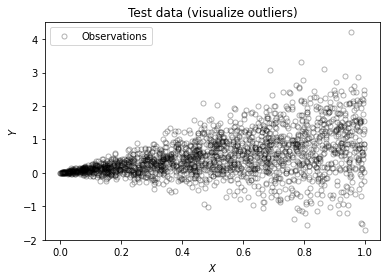

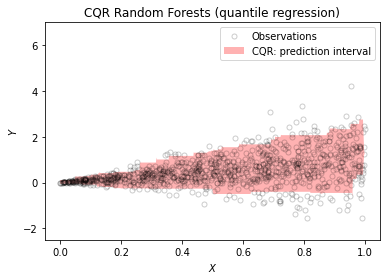

In [44]:
save_figures = False
split_color = 'tomato'
local_color = 'gray'
cqr_color = 'red'
max_show = 1000

%matplotlib inline
# display the test data in full range (including the outliers)
fig = plt.figure()
plt.plot(x_test, y_test, 'k.', alpha = 0.3, markersize=10,
         fillstyle='none', label=u'Observations')
plt.legend()
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title('Test data (visualize outliers)')
if save_figures:
    plt.savefig("illustration_test_data.png",
                bbox_inches='tight', dpi=300)
plt.show()

plot_func(x=x_test,y=y_test,y_u=res[:,1],y_l=res[:,0],shade_color=cqr_color,
          method_name="CQR:",title="CQR Random Forests (quantile regression)",
          filename="illustration_split_qrf.png",save_figures=save_figures)

In [81]:
x, y = test_dgp(2000)
y = y.flatten()
param_grid = {'n_estimators': [5, 900]}
regressor = SplitConformalRegressor(RandomForestRegressor(), method="mean-based", param_grid=param_grid)
#grid = GridSearchCV(RandomForestRegressor(),param_grid, refit = True, scoring=scoring_object)
# fitting the model for grid search 
res = regressor.tune(X=x,y=y)

In [88]:
est = RandomForestRegressor(n_estimators=5)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

y_pred = est.fit(X_train, y_train).predict(X_test)
loss = -np.mean((y_test - y_pred)**2)

In [89]:
loss

-0.5713299481236639

In [91]:
from sklearn.ensemble import GradientBoostingRegressor

In [126]:
x, y = test_dgp(2000)
y = y.flatten()
param_grid = {'learning_rate': [0.1, 0.08, 0.5], 'min_samples_leaf': [2,8,15]}

regressor = SplitConformalRegressor(GradientBoostingRegressor, method="quantile-based", param_grid=param_grid)
res = regressor.tune(X=x,y=y)

{'learning_rate': [0.1, 0.08, 0.5], 'min_samples_leaf': [2, 8, 15], 'loss': ['quantile'], 'alpha': [0.9]}


In [124]:
res.cv_results_["mean_test_score"]

array([-36.11411493, -36.42638964, -36.5314964 , -36.06946284,
       -36.45393189, -36.35014578, -36.71057235, -37.09922899,
       -38.1875    ])

In [172]:
x, y = test_dgp(2000)
y = y.flatten()
param_grid = {'nodesize': [2, 80]}

regressor = SplitConformalRegressor(QuantregForest, method="quantile-based", param_grid=param_grid)
res = regressor.tune(X=x,y=y)

{'nodesize': [2, 80], 'loss': ['quantile'], 'alpha': [0.9]}


In [35]:
from sklearn.ensemble import GradientBoostingRegressor

In [45]:
x, y = test_dgp(2000)
x_test, y_test = test_dgp(2000)

y_test = y_test.flatten()
y = y.flatten()

#X_train, X_conf, y_train, y_conf = train_test_split(x, y, test_size=0.3)

#res = pred_band_quantile_based_rf(X_predict=x_test, X_train=X_train, y_train=y_train, X_conf=X_calib, y_conf=y_calib, nodesize=50)
regressor = SplitConformalRegressor(GradientBoostingRegressor, method="quantile-based")

regressor = regressor.fit(X=x, y=y, params={"alpha": np.array([0.05,0.95])})
res = regressor.predict_intervals(X_pred=x_test)

length_cqr_rf = res[:,1] - res[:,0]

# compute and display the average length
print("CQR Random Forests: Average length:", np.mean(length_cqr_rf))

in_the_range = np.sum((y_test.flatten() >= res[:,0]) & (y_test.flatten() <= res[:,1]))

print("CQR Random Forests: Percentage in the range (expecting " + str(100*(1-0.1)) + "%):",
      in_the_range / len(y_test) * 100)

ValueError: Invalid estimator or params. Please provide a quantile regression estimator with the corresponding params.